In [23]:
import sys
import os
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF
import gc
import collections
import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import pyproj
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean
from matplotlib import animation, rc

# Third-party dependencies
# NOTE: Local xeofs to be submitted as pull-request (addition of xeofs.model.reconstruct_randomized_X method)
from xeofs.xarray import EOF
from xarrayutils.utils import linear_trend

In [51]:
# Define local plotting parameters
#sns.set_theme(style="whitegrid")
#sns.set_theme(style="ticks")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.rcParams.update({'font.size': 15})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')
plt.rc('text', usetex=True)

## Define directories

In [3]:
# To update following with relative repository paths once data and code is up on Zenodo
# Current version uses the project template on Github.

# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS
# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'
# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Relative directory paths for Data and Figures
figures_folderpath = 'reports/figures/'
interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
cise_file_path = 'cise_data/'

## Input data files and catchment masks for ice shelves

### Catchment boundary masks

In [49]:
# Catchment boundary masks for Antarctica, taken from ice shelf definitions in MPAS-Dev/geometric-features
# Source: https://github.com/MPAS-Dev/geometric_features/tree/main/geometric_data
# These have been combined into one file with 133 defined regions (polygons and multipolygons), 
# readable via the Geopandas package

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)

# Convert to south polar stereographic projection
#icems = iceshelvesmask.to_crs({'init': 'epsg:3031'}); # This has been deprecated
icems = iceshelvesmask.to_crs('epsg:3031');
crs = ccrs.SouthPolarStereo();

### Plot catchment boundaries

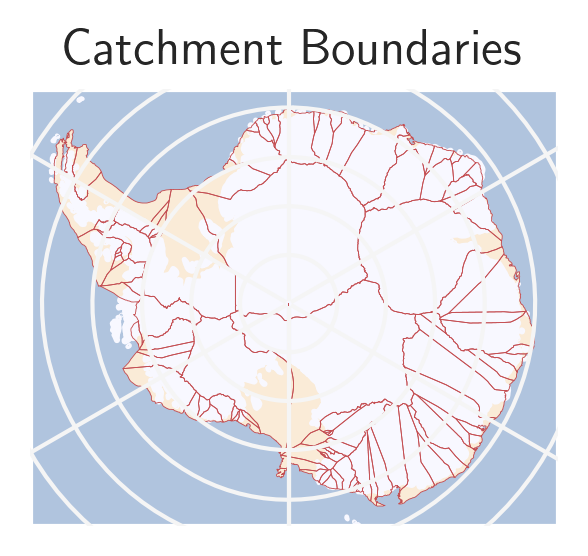

In [52]:
# Plot boundaries

plt.figure(figsize=(5,5))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='r', linewidth=0.2,zorder=3)
#icems[34:133].boundary.plot(ax=ax1,linewidth=0.25,color='lightgray',zorder=4)
#ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

### Ocean forcing data

In [5]:
# Original forcing data: raw MPAS-O output, mapped to the 10km resolution grid
# flux is freshwater flux
# ssh is sea surface height, used here as a proxy for ice draft / depth.

# ssh is used to plot the scatterplot of flux vs. draft for different ice shelves 
# and as input for the linear regression used in "dedrafting" the dataset

regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

# Pre-processed data: detrended, deseasonalized, dedrafted
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

# Dedrafted flux
flux_dedrafted = xr.open_dataset(inDirName+
                                 interim_data_folder+
                                 flux_dedrafted_iceshelves_data_path+'iceshelves_dedrafted_total.nc')
flux_dedrafted = flux_dedrafted.timeMonthly_avg_landIceFreshwaterFlux

# Flux datapoints extracted for individual ice shelves, used for the scatter plots
catchments_scatter = np.load(inDirName+interim_data_folder+"catchments_scatter.npy")
catchments_scatter_xr = xr.DataArray(catchments_scatter,dims={'basin','x','y'})

# Add reconstructed datasets - seed random

### Plot sample data for specific ice shelves (melt rate draft dependence)

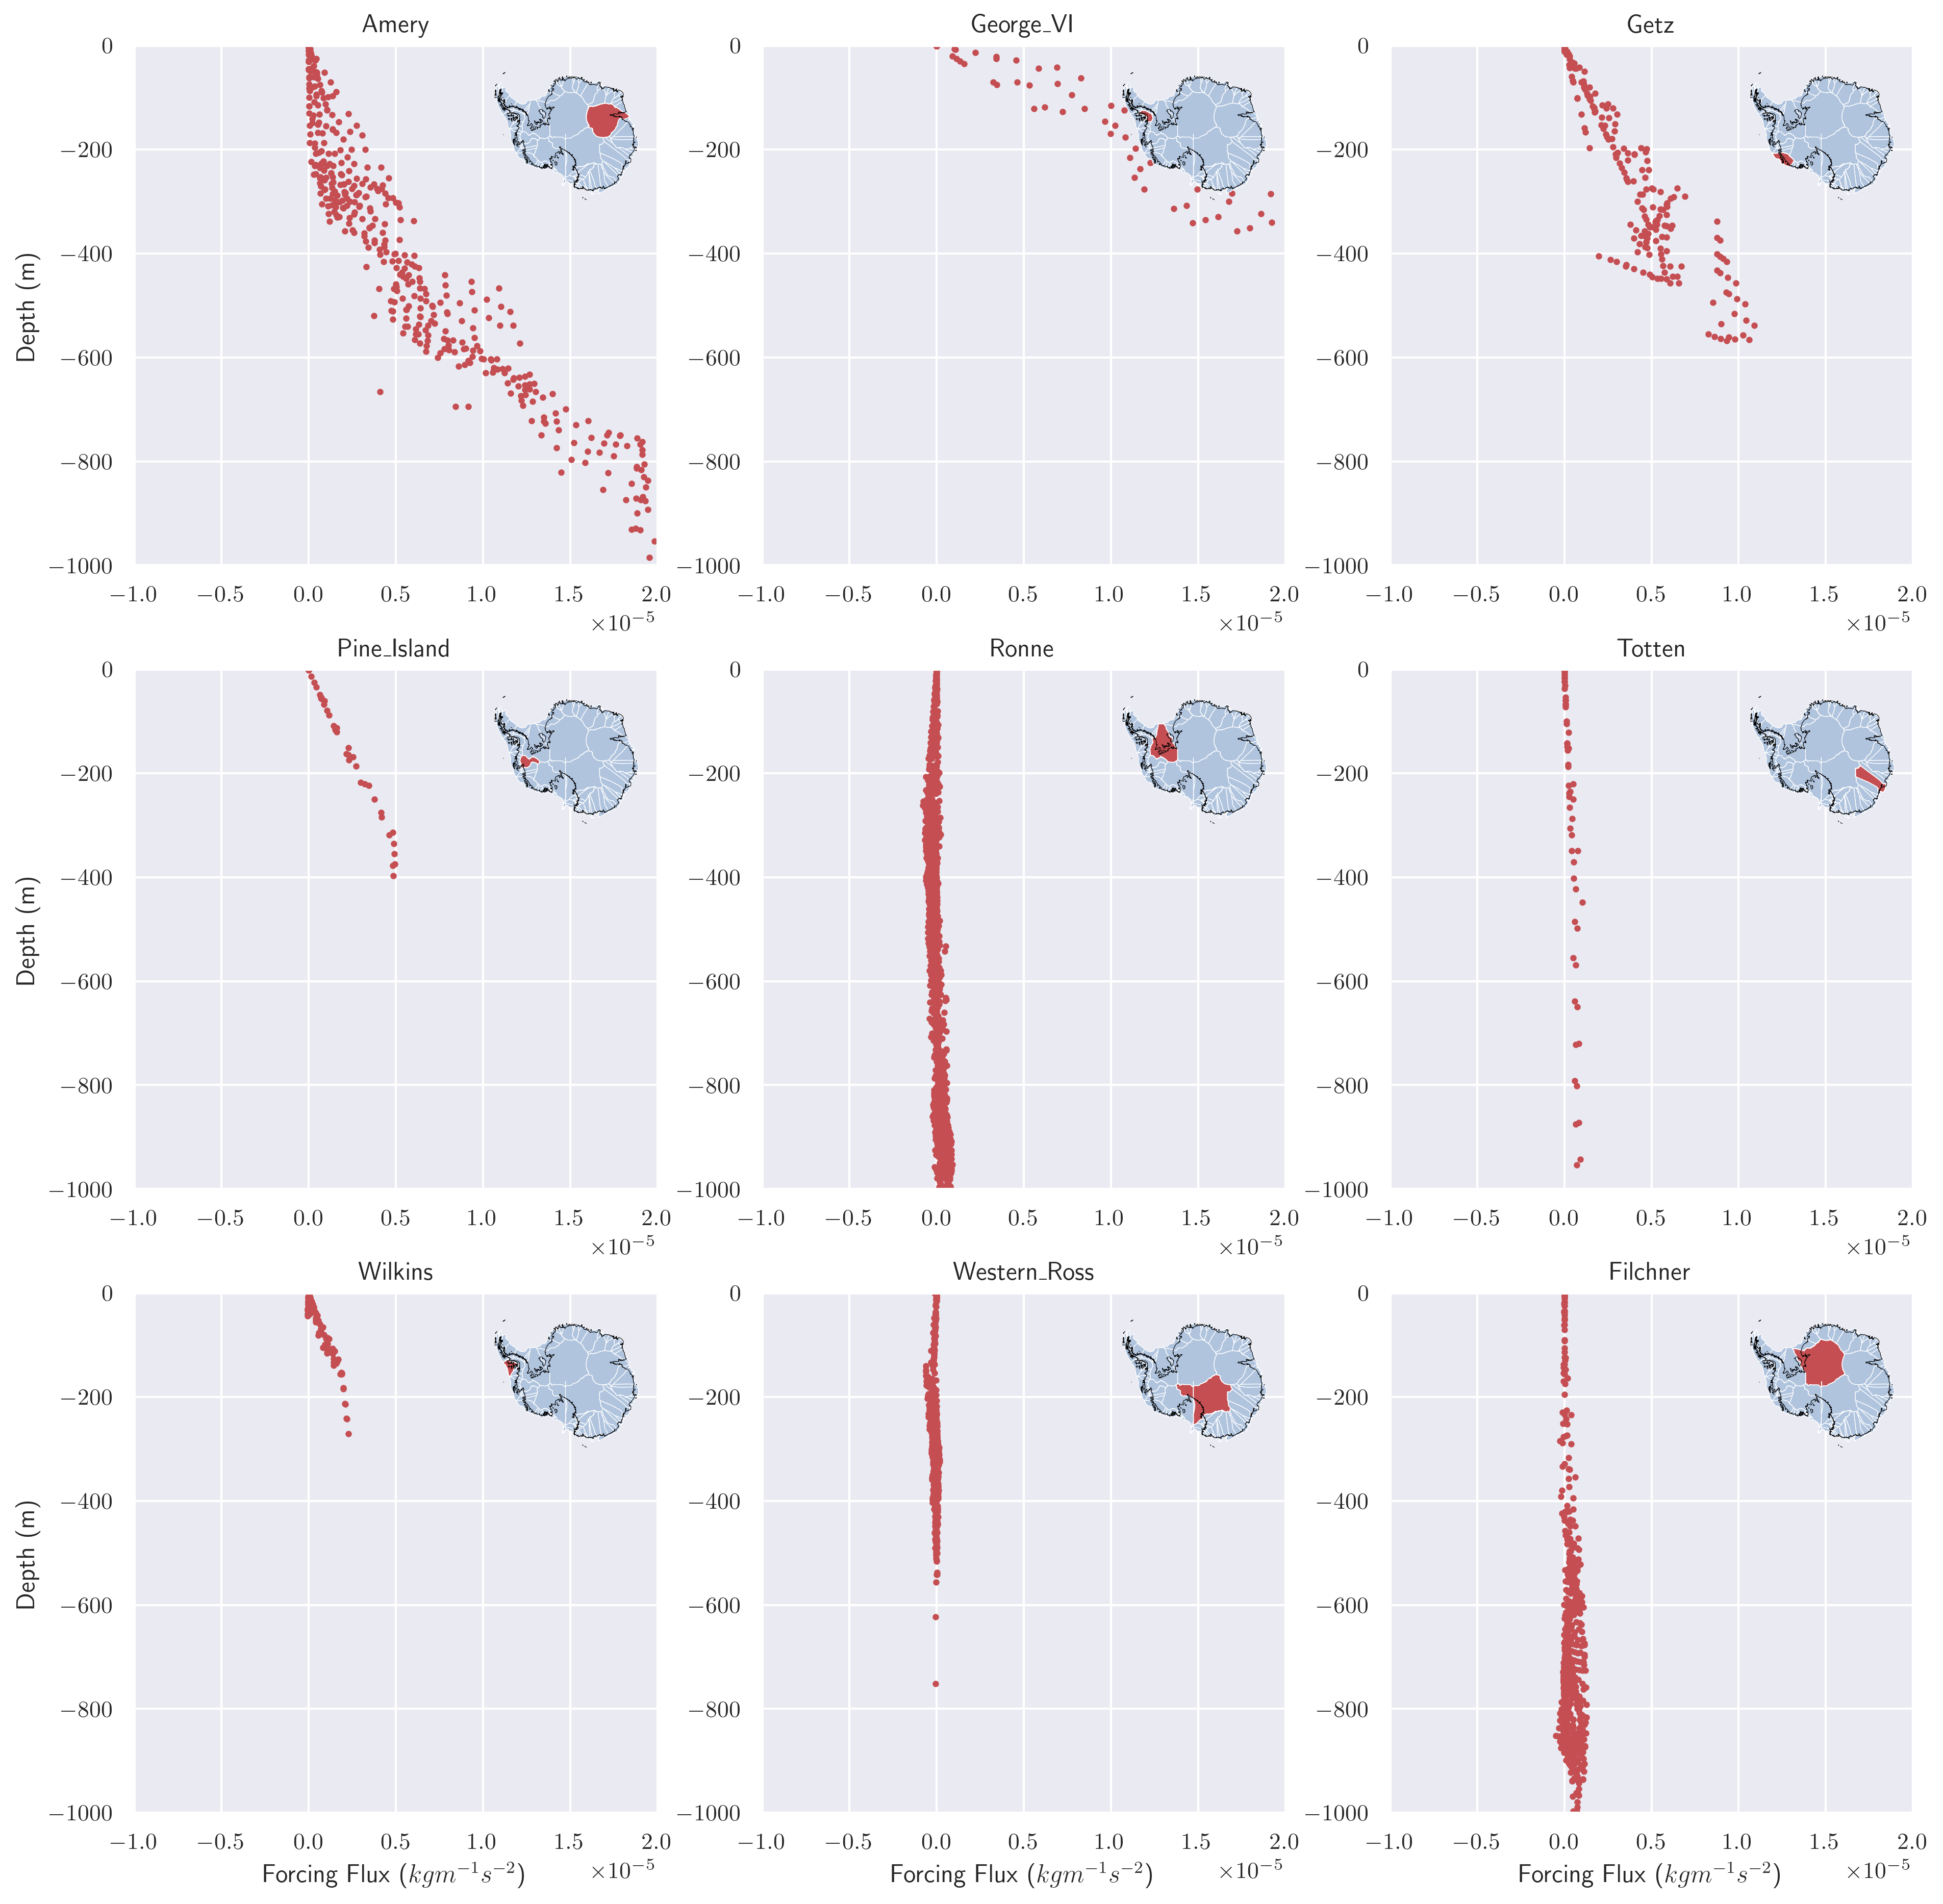

In [36]:
# Figure: Melt rate draft dependence for select catchments
# The following indices are taken from 'catchment_scatter', defined as
# Index of catchments in catchment_scatter = Index of catchments in icems - 33

# Sample ice shelves chosen:
# Amery = 1
# George VI = 27
# Getz = 28
# Pine Island = 61
# Ronne = 70
# Totten = 83
# Wilkins = 94
# Western Ross = 71
# Filchner = 22
# Thwaites = 81
# Eastern_Ross = 72

# Full list of ice shelves and indices can be obtained by printing icems

catchments = np.array([1,27,28,61,70,83,94,71,22])

#fig, ax = plt.subplots(1, 1, figsize=[15, 15],subplot_kw={'projection': ccrs.SouthPolarStereo()})
fig, axs = plt.subplots(3,3, figsize=[15, 15])
axs=axs.ravel()

for i in range(9):
    axs[i].scatter(catchments_scatter[catchments[i]],ssh[1],color='r',s=4)
    #axs[i].set_xlabel('Melt Flux (kg / m2 / s)')
    #axs[i].set_ylabel('Depth (m)')
    axs[i].set_ylim(-1000,0) # Specified for consistency across plots, some catchments are not as deep as others
    # Uncomment to set xlim values for easy comparison of forcing magnitudes (varies across ice shelves)
    # axs[i].set_xlim(-1e-5,2e-5)
    axs[i].set_title(icems.name[33+catchments[i]])
    # axs[i].inset_axes([], projection=crs) does not seem to work, hence the workaround below:
    # Refer here: https://github.com/matplotlib/matplotlib/pull/22608 for future revisions
    axins = inset_axes(axs[i],width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axins,linewidth=0.3,color='lightsteelblue')
    axins.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[33+catchments[i]],'geometry'].plot(ax=axins,color='r',linewidth=0.4)
    axins.set_axis_off();

axs[0].set_ylabel('Depth (m)'); # Ice Draft?
axs[3].set_ylabel('Depth (m)');
axs[6].set_ylabel('Depth (m)');


axs[6].set_xlabel('Forcing Flux ($kg m^{-1}s^{-2}$)');
axs[7].set_xlabel('Forcing Flux ($kg m^{-1}s^{-2}$)');
axs[8].set_xlabel('Forcing Flux ($kg m^{-1}s^{-2}$)');

# TODO: Convert to m SLE units for flux

# Data Pre-Processing

For time series plots and comparisons, the sum of flux across the spatial domain (or specific ice shelves) is used as a proxy when required. The mean can also be used here, without any loss of information, as the idea is only to compare trendlines.
#### TODO: Verify if this is indeed true

However, this might not be possible once the data is normalized, as the magnitude of data is removed at that stage.

In [ ]:
flux_ts = flux.sum(['x','y'])
flux_dedrafted_ts = flux_dedrafted.sum(['x','y'])

# Processed data time series
flux_clean_ts = flux_clean.sum(['x','y'])

In [ ]:
# Remove temporal mean
# Is this necessary?
flux_demeaned = flux - flux.mean('time')
flux_demeaned_ts = flux_demeaned.sum(['x','y'])

## Remove seasonality

In [ ]:
# Deseasonalize
# Remove climatologies to isolate anomalies, i.e., internal variability
flux_month = flux_dedrafted.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [ ]:
flux_clm_ts = flux_clm.sum(['x','y'])
flux_anm_ts = flux_anm.sum(['x','y'])

In [ ]:
plt.figure(figsize=(25,6))
plt.plot(flux_ts[300:])
plt.plot(flux_dedrafted_ts[300:])
#plt.plot(flux_clean_ts)
plt.plot(flux_anm_ts[300:])

In [ ]:
# Sanity check, as "flux_clean.nc" was created earlier. The difference here is purely numerical.

plt.figure(figsize=(25,6))
plt.plot(flux_clean_ts - flux_anm_ts[300:])

# EOF/PCA Decomposition

### Data Normalization

In [53]:
flux_clean_tmean = flux_clean.mean('time')
flux_clean_tstd = flux_clean.std('time')

flux_clean_demeaned = flux_clean - flux_clean_tmean
# Why does this introduce a non-zero change? (Artefact of flux variable dimensions?)
flux_clean_normalized = flux_clean_demeaned/flux_clean_tstd

Time series of the normalized data is calculated below only for illustrative purposes. It would not make sense to compare the normalized time series to other time series (which use the spatial sum or mean).

In [ ]:
# flux_clean_normalized_ts = flux_clean_normalized.mean(['x','y'])

Text(0.5, 0, 'Time (months)')

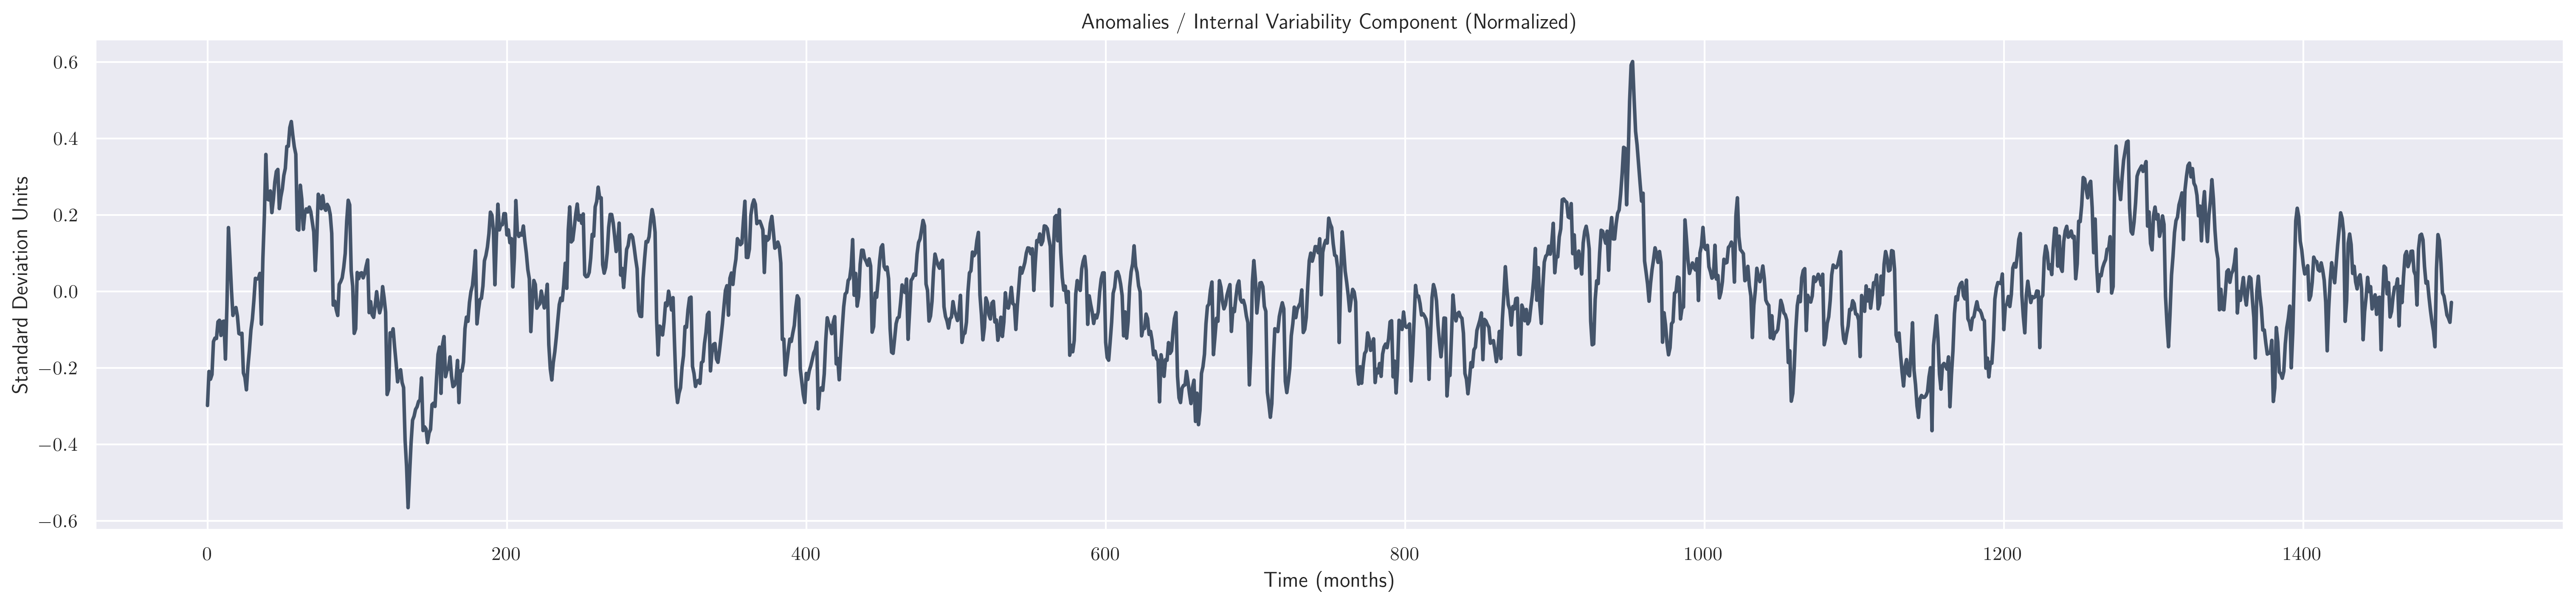

In [54]:
plt.figure(figsize=(25,5))
plt.plot(flux_clean_normalized_ts,color = '#44546A', linewidth=2)
plt.title('Anomalies / Internal Variability Component (Normalized)');
plt.ylabel('Standard Deviation Units');
plt.xlabel('Time (months)');

## Spatial Decomposition: EOF Analysis

EOF decomposition is done using a modified version of the `xeofs` package.
Refer [nicrie/xeofs](https://github.com/nicrie/xeofs) on Github for documentation.

#### TODO: Upload modification of `xeofs` online, or rewrite Xarray wrapper for the scikit-learn PCA to encompass full workflow

In [161]:
%%time
model = EOF(flux_clean_normalized)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()
pcs_eig = model.pcs(1)
pcs_sng = model.pcs(2)

CPU times: user 59.3 s, sys: 24.8 s, total: 1min 24s
Wall time: 26.9 s


### Plot relative power of first m modes from the PCA decomposition

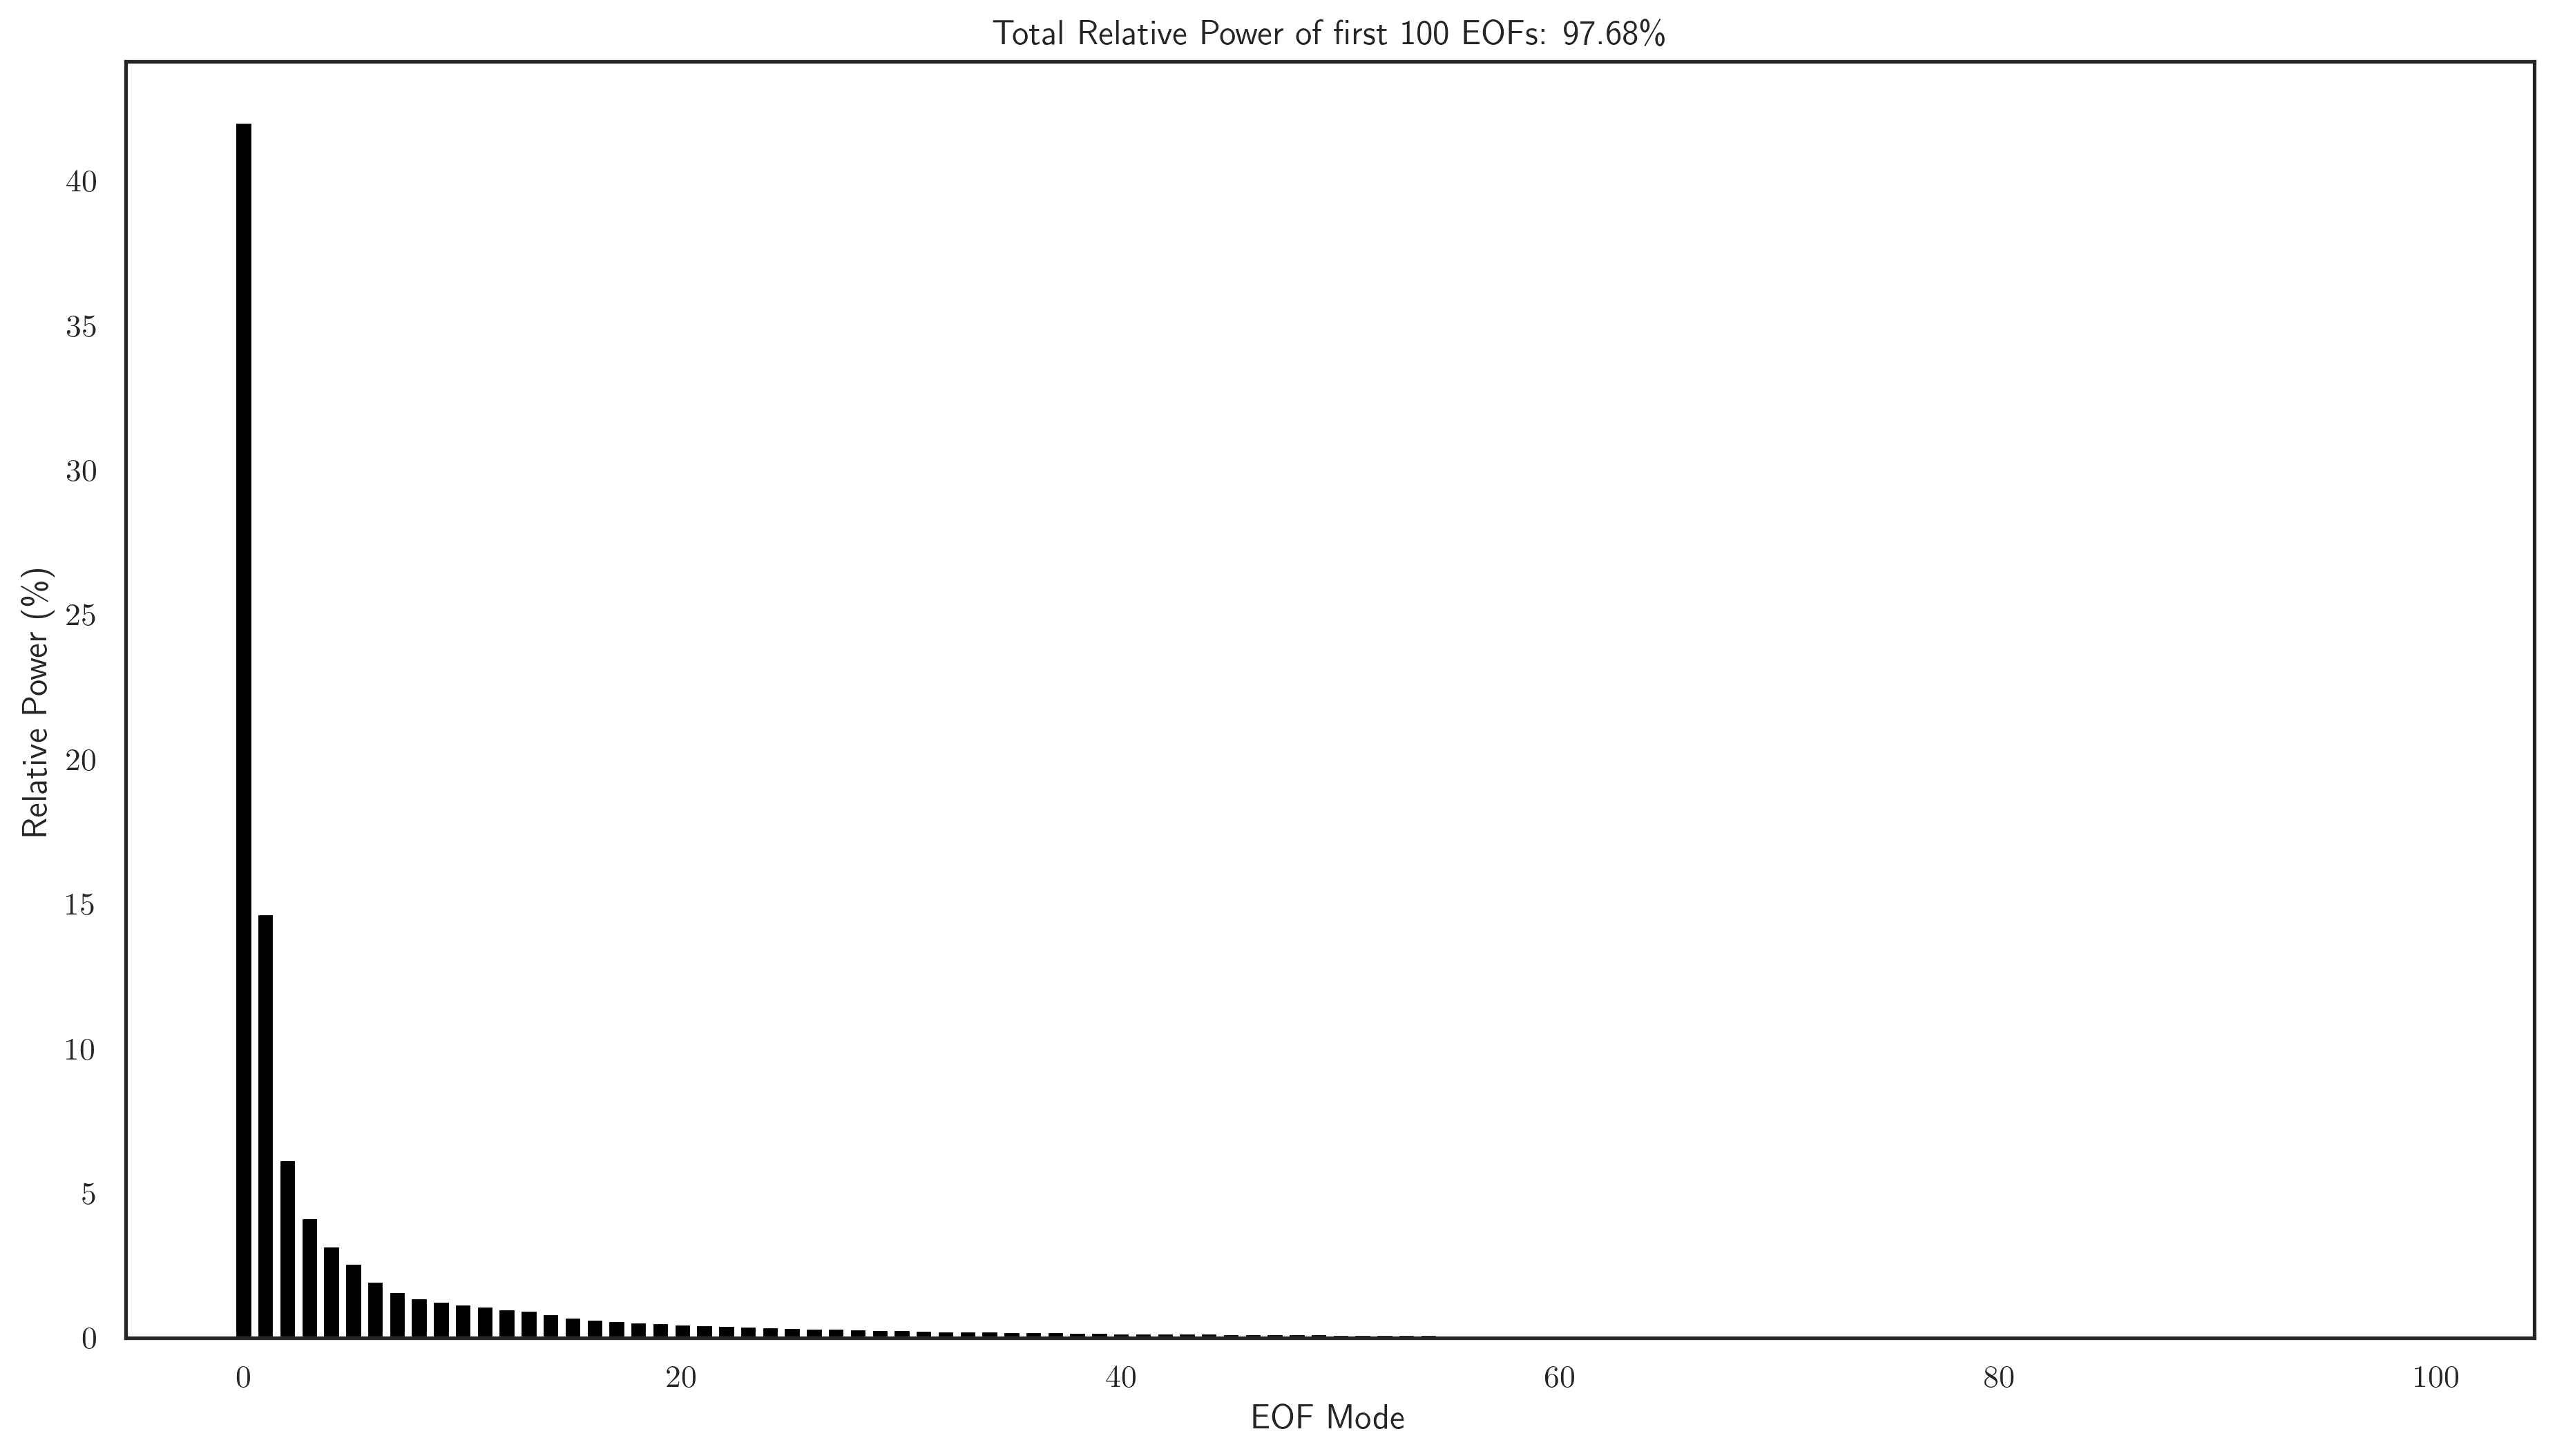

In [156]:
# Figure: Relative power of m EOFs
m = 100

plt.figure(figsize=(15,8))
plt.bar(range(m),varexpl[:m]*100, 
        color='black')
plt.ylabel('Relative Power (\%)')
plt.xlabel('EOF Mode')
plt.title('Total Relative Power of first {} EOFs: {:.2f}\%'.format(m, varexpl[:m].sum().values*100));

### Plot dominant modes of variability: EOF spatial modes and PC series
The plots show dominant spatial and temporal modes of variability for the normalized dataset. It is difficult to interpret these physically.
#### TODO: Define vmax, vmin params for eofs.plot() if plotting for original cleaned dataset (un-normalized data)

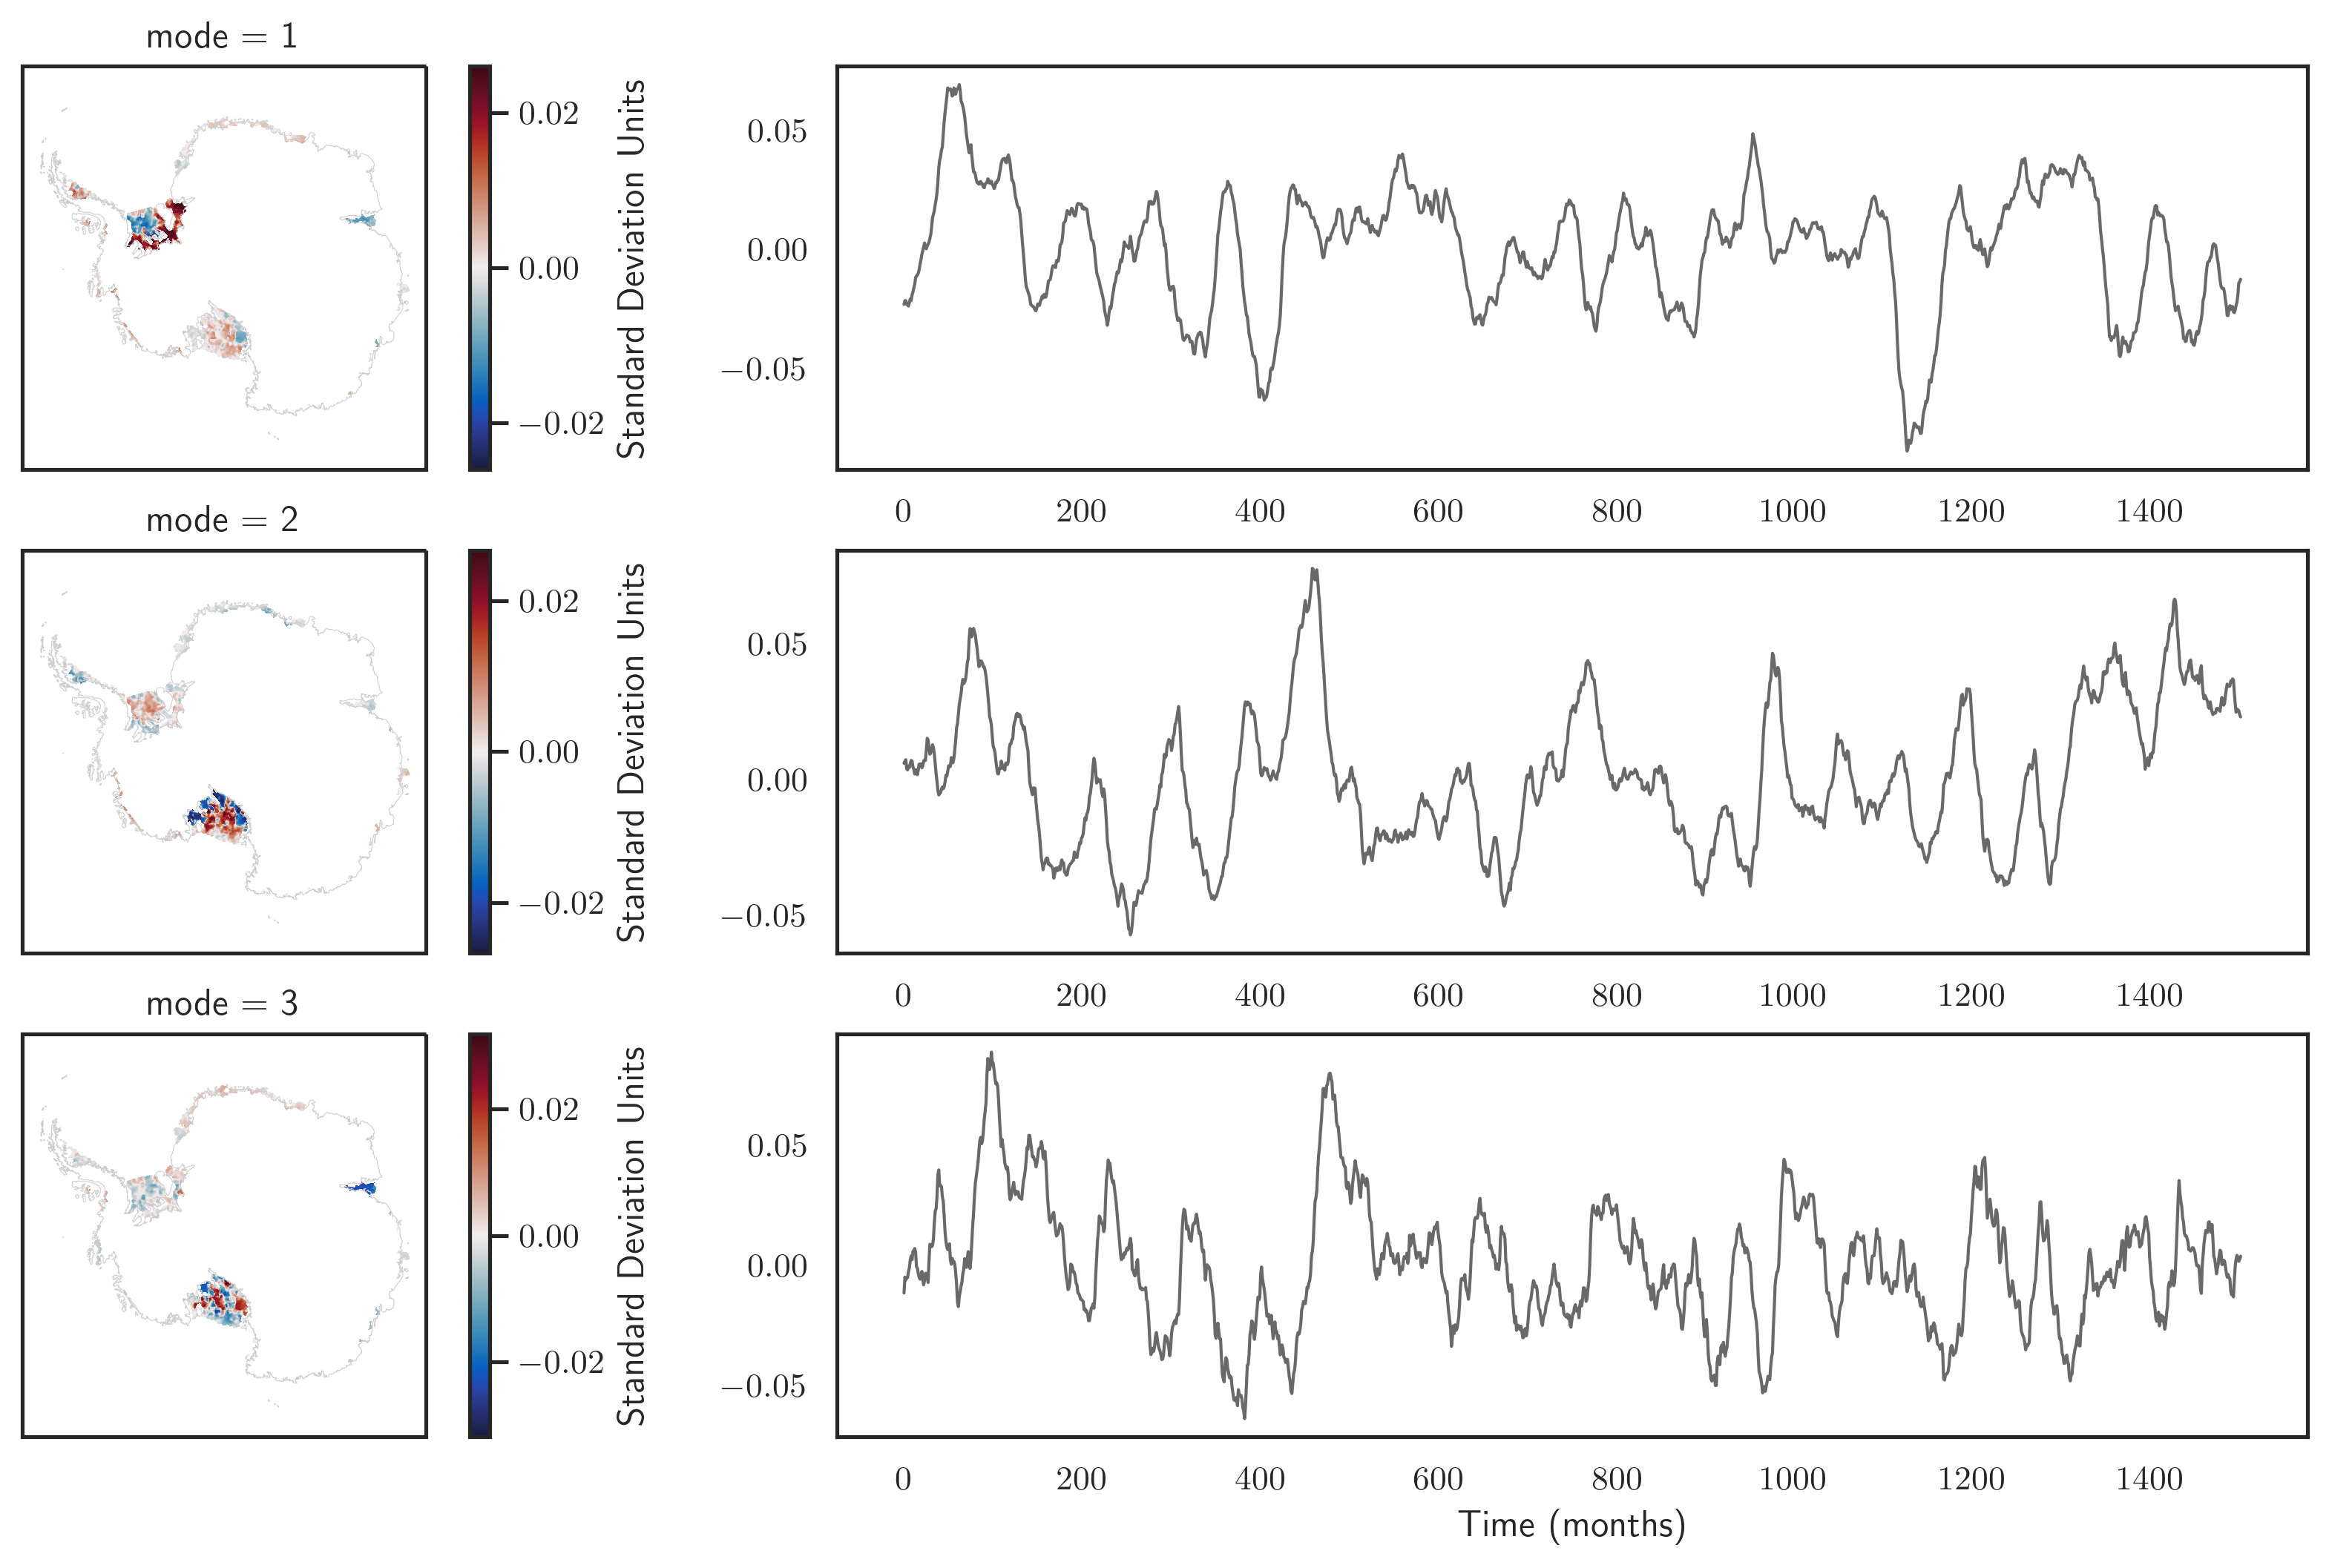

In [169]:
nmodes_plot = 3 # Number of modes to plot
fig=plt.figure(figsize=(15,8))
gs = GridSpec(nmodes_plot,2,width_ratios=[1.5,2.5])
ax0 = [fig.add_subplot(gs[i, 0],projection=crs) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    eofs.sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=True,
                            cbar_kwargs={'orientation': 'vertical',
                                         'label': 'Standard Deviation Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a1.plot(pcs.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')

a1.set_xlabel('Time (months)');
#cb = plt.colorbar(eofs.sel(mode=1), ax=a0, orientation="vertical", pad=0.15)


"""
# Figure: Dominant EOF modes
sns.set_theme(style="white")
fg = eofs[:,:,0:2].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=2,
                        cmap='cmo.balance', # Uses cmocean colorbar - should be installed
                        cbar_kwargs={'orientation': 'vertical',
                                    'label': 'Standard Deviation Units'},
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

[ax.coastlines() for ax in fg.axs.flatten()];
"""

## Fourier Phase Randomization

Now, the projection co-efficients from the previous step are phase-randomized to generate new realizations of the data. In this step, we sample phases for each FFT(PC) from (0,$2\pi$), and iterate to generate n realizations.

In [171]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 3
t_length = pcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        #random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
    print('calculated ifft for realization {}, all modes'.format(i))

calculated ifft for realization 0, all modes
calculated ifft for realization 1, all modes
calculated ifft for realization 2, all modes
CPU times: user 838 ms, sys: 20.9 ms, total: 858 ms
Wall time: 856 ms


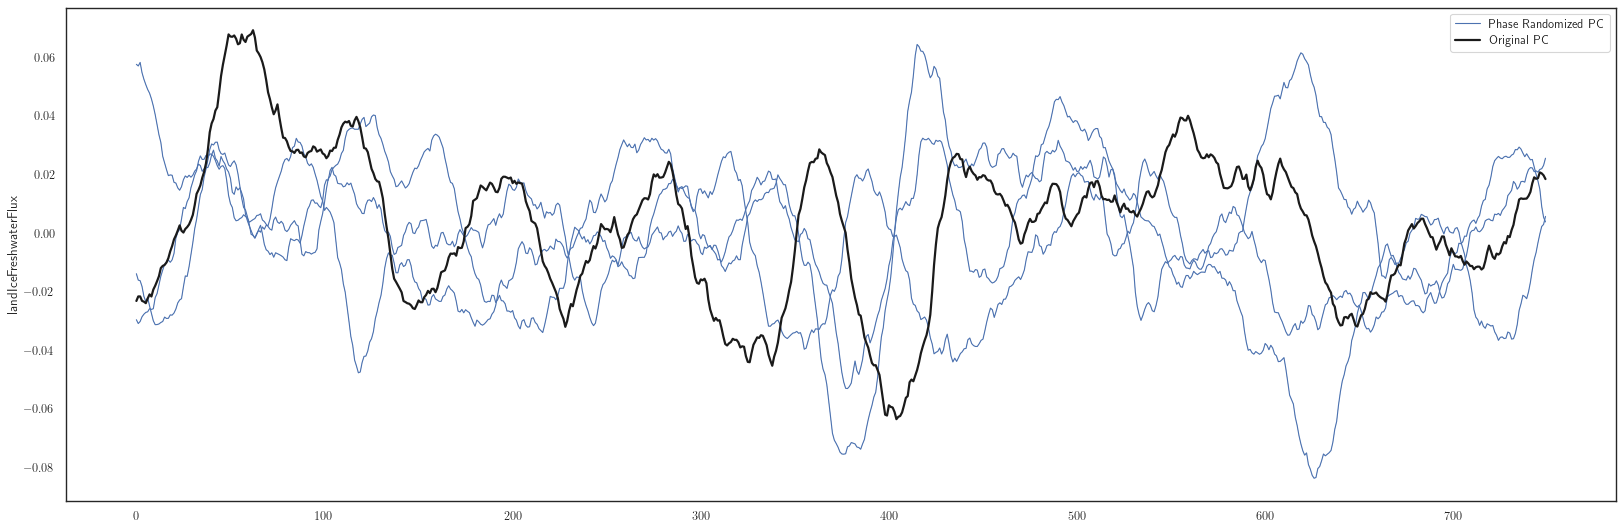

In [179]:
plt.figure(figsize=(25, 8), dpi=80)

for i in range(n_realizations):
    plt.plot(new_fl[i,t1:tf,0],'b', linewidth=0.15)

plt.plot(new_fl[0,t1:tf,0],'b', linewidth=1, label='Phase Randomized PC')
plt.plot(new_fl[1,t1:tf,0],'b', linewidth=1)
plt.plot(new_fl[2,t1:tf,0],'b', linewidth=1)
plt.plot(pcs[t1:tf,0],'k', linewidth=2, label='Original PC')
#plt.title('Deseasonalized and Detrended Flux (Years: {:.1f} - {:.1f})'.format((spinuptime+t1)/12,(spinuptime+tf)/12))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

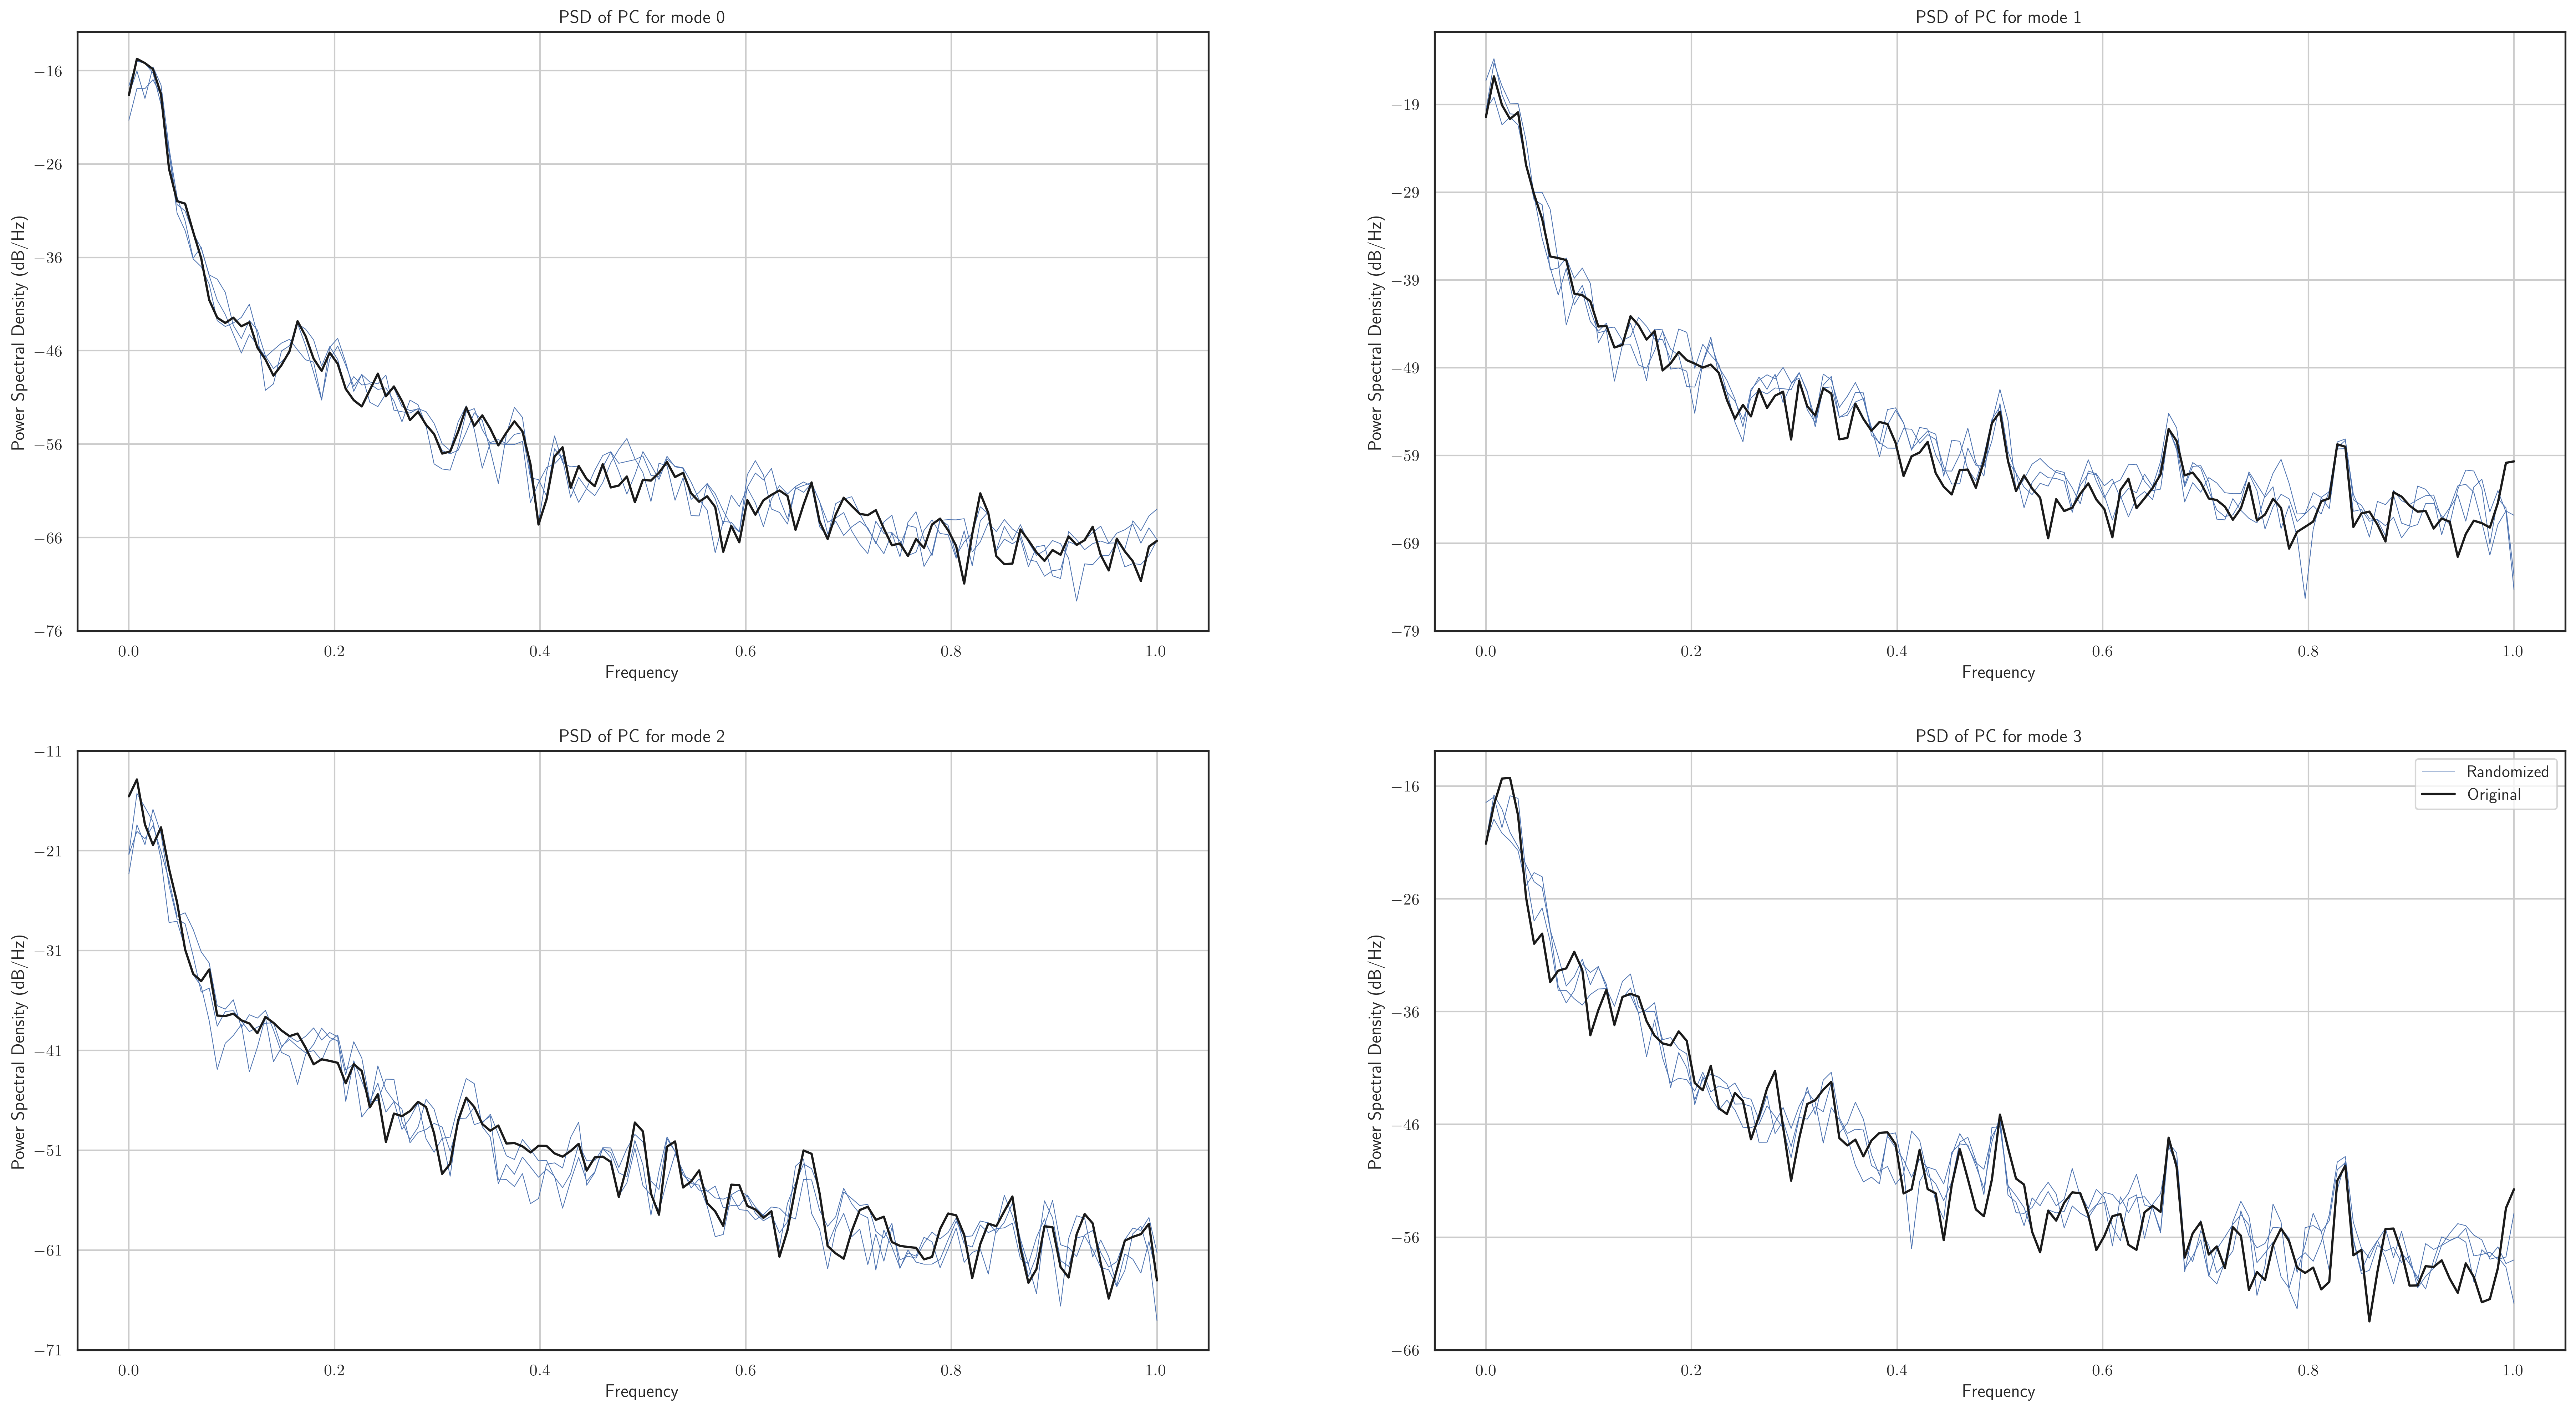

In [180]:
# FIGURE (FOR TESTING)

fig, axs = plt.subplots(2,2,figsize=(30,16))
axs=axs.ravel()

for mode_m in range(0,4):
    for i in range(0,3):
        axs[mode_m].psd(new_fl[i,:,mode_m],color='b', linewidth=0.5)
    axs[mode_m].psd(new_fl[0,:,mode_m],color='b', linewidth=0.25,label='Randomized')
    axs[mode_m].psd(pcs[:,mode_m],color='k', linewidth=1.5,label='Original')
    axs[mode_m].set_title('PSD of PC for mode {}'.format(mode_m))
plt.legend()